In [2]:
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
tf.get_logger().setLevel('ERROR')

In [23]:
try:
    strategy = tf.distribute.OneDeviceStrategy("GPU:0")
except:
    # 若無法使用 GPU，則使用預設策略
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [56]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
file_path_monet = './/gan-getting-started//monet_tfrec'
MONET_FILENAMES = tf.io.gfile.glob(file_path_monet+'/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

file_path_photo = './/gan-getting-started//photo_tfrec'
PHOTO_FILENAMES = tf.io.gfile.glob(file_path_photo + '/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [25]:
def decode_image(image):
    # 解碼JPEG格式的圖像，通道數為3
    image = tf.image.decode_jpeg(image, channels=3)
    # 將像素值轉換為tf.float32類型，進行範圍縮放，並進行正規化，使像素值在[-1, 1]之間
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    # 將圖像形狀重塑為指定的IMAGE_SIZE
    image = tf.reshape(image, [256, 256, 3])
    # 返回處理後的圖像
    return image



def read_tfrecord(example):
    # 定義解析TFRecord數據格式的字典，包含三個特徵："image_name"、"image"和"target"
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    # 解析單個TFRecord數據樣本example
    example = tf.io.parse_single_example(example, tfrecord_format)
    # 讀取"image"特徵的值，將其解碼並進行預處理，得到一個圖像Tensor
    image = decode_image(example['image'])
    # 返回預處理後的圖像Tensor
    return image



def load_dataset(filenames, labeled=True, ordered=False):
    # 從文件名列表讀取TFRecord格式數據，返回一個TFRecordDataset對象
    dataset = tf.data.TFRecordDataset(filenames)
    # 使用read_tfrecord函數對每個樣本進行解析，返回解析後的Tensor
    # num_parallel_calls參數指定了解析過程的並行度，可以提高解析效率
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset


In [37]:
# batch方法將每個批次中的樣本數量設置為1，即每次只加載一張圖片，這樣有助於在GPU內存有限的情況下避免內存溢出。
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(4)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(4)


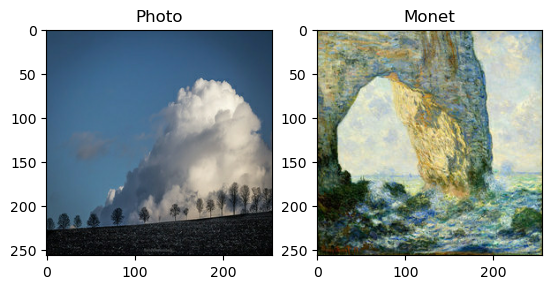

In [38]:
# 各取出一張圖
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [39]:
def downsample(filters, size, apply_instancenorm=True):
    # 設定權重初始化器和 gamma 參數初始化器
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    # 添加卷積層，使用2倍下採樣的步長
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    # 若需要使用 InstanceNormalization，則添加對應層
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    # 添加 LeakyReLU 激活函數
    result.add(layers.LeakyReLU())
    return result


In [40]:
def upsample(filters, size, apply_dropout=False):
    # 定義初始化權重的方式
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    # 反卷積層進行上採樣
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    # 在每一層後加上 InstanceNormalization
    # 使用 tfa.layers.InstanceNormalization(gamma_initializer=gamma_init) 
    # 是為了在每一層的上採樣過程中應用實例標準化（Instance Normalization）
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        # 在訓練階段對輸入進行dropout
        result.add(layers.Dropout(0.5))

    # 使用ReLU作為激活函數
    result.add(layers.ReLU())

    return result


In [41]:
def Generator():
    # 輸入層，輸入大小為256x256x3的圖像
    inputs = layers.Input(shape=[256,256,3])
    
    # 定義編碼器部分，共8層下採樣操作，每層都包含一個下採樣層
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    # 定義解碼器部分，共7層上採樣操作，每層都包含一個上採樣層
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)

    # 定義最後一層，上採樣2倍，使用 tanh 激活函數輸出生成圖像
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x) # 下採樣操作
        skips.append(x) # 記錄 skip connection 的輸出

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x) # 上採樣操作
        x = layers.Concatenate()([x, skip]) # 與對應的 skip connection 輸出進行連接

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x) # 定義生成器模型，


In [42]:
import tensorflow_addons as tfa

def Discriminator():
    # 定義初始化權重的方式
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    # 定義輸入層
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    # 進行下採樣
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    # 在下採樣後的特徵圖周圍填充 0 避免在卷積過程中邊緣像素的信息損
    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    # 進行卷積操作
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    # 進行 Instance Normalization
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    # 使用 LeakyReLU 作為激活函數
    leaky_relu = layers.LeakyReLU()(norm1)

    # 再次進行填充 0
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    # 最後一層卷積輸出單一通道
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    # 定義模型的輸入和輸出
    return tf.keras.Model(inputs=inp, outputs=last)


In [43]:
with strategy.scope():
    monet_generator = Generator()  # 將照片轉換為莫內風格的畫作的生成器
    photo_generator = Generator()  # 將莫內畫作轉換為更像照片的生成器

    monet_discriminator = Discriminator()  # 區分真實莫內畫作和生成的莫內畫作的判別器
    photo_discriminator = Discriminator()  # 區分真實照片和生成的照片的判別器


In [44]:
# Build the CycleGAN model

class CycleGan(keras.Model):
    
    # 初始化函數
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
    
    # 配置模型的訓練過程
    def compile(
    self,
    m_gen_optimizer,
    p_gen_optimizer,
    m_disc_optimizer,
    p_disc_optimizer,
    gen_loss_fn,
    disc_loss_fn,
    cycle_loss_fn,
    identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
    
    
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo 轉 monet 轉回 photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet 轉 photo 轉回 monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # 真實圖片產身真實結果
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # 鑑別器對於真實圖像的評估結果
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # 鑑別器對於假圖像的評估結果
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # 計算損失
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # 循環一致性損失是指在循環生成對抗網絡（CycleGAN）中，
            # 經過兩個生成器進行圖像轉換後 再轉換回原始圖像時
            # 生成的圖像應該與原始圖像保持一致
            # 有助於確保生成器能夠在圖像轉換過程中保持圖像的內容和特徵。
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # 評估整個LOSS
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # 評估兩格鑑別器的LOSS
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [45]:
# 定義損失函數

with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5 # 返回判別是的總體損失 *0.5 目的在於降低判別器的權重

    
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

    
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss 

with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

    
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [46]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [47]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)


Epoch 1/25
75/75 [==============================] - 59s 350ms/step - monet_gen_loss: 7.3563 - photo_gen_loss: 7.6235 - monet_disc_loss: 0.6174 - photo_disc_loss: 0.6163
Epoch 2/25
75/75 [==============================] - 26s 350ms/step - monet_gen_loss: 4.9915 - photo_gen_loss: 5.0517 - monet_disc_loss: 0.5319 - photo_disc_loss: 0.5574
Epoch 3/25
75/75 [==============================] - 26s 353ms/step - monet_gen_loss: 4.2218 - photo_gen_loss: 4.5659 - monet_disc_loss: 0.6529 - photo_disc_loss: 0.4279
Epoch 4/25
75/75 [==============================] - 27s 358ms/step - monet_gen_loss: 3.8619 - photo_gen_loss: 4.5198 - monet_disc_loss: 0.6622 - photo_disc_loss: 0.3544
Epoch 5/25
75/75 [==============================] - 27s 364ms/step - monet_gen_loss: 3.8230 - photo_gen_loss: 4.6630 - monet_disc_loss: 0.6418 - photo_disc_loss: 0.3400
Epoch 6/25
75/75 [==============================] - 27s 361ms/step - monet_gen_loss: 3.7554 - photo_gen_loss: 4.6613 - monet_disc_loss: 0.6743 - photo_disc

In [49]:
#  If you want to see a list of allocated tensors when OOM happens, 
# add report_tensor_allocations_upon_oom to RunOptions for current allocation info. 
# This isn't available when running in Eager mode.
# 出現此訊息請調整 BATCHSIZE

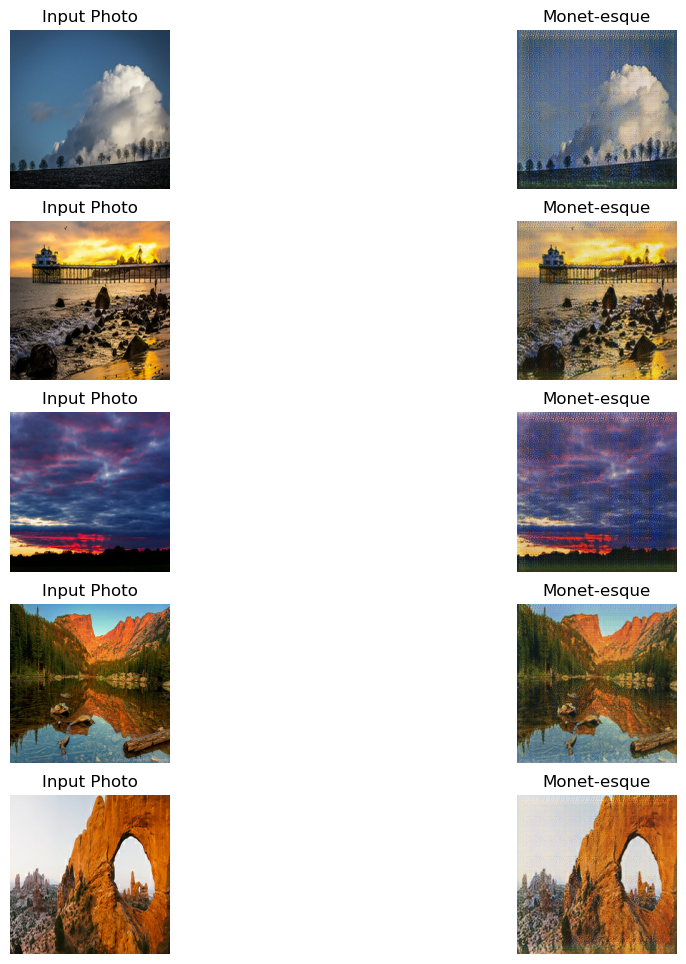

In [54]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()